In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

In [2]:
model_families = [
    ['wiki_cnn_v3_100'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    #['wiki_debias_cnn_v3_100', 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
]

In [13]:
# Read the scored data into DataFrame
balanced_madlibs = pd.read_csv('eval_datasets/bias_madlibs_77k_scored.csv')
balanced_madlibs.head()

,Unnamed: 0,text,Template,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_102,wiki_cnn_v3_103,wiki_cnn_v3_104,wiki_cnn_v3_105,...,wiki_debias_cnn_v3_100,wiki_debias_cnn_v3_101,wiki_debias_cnn_v3_102,wiki_debias_cnn_v3_103,wiki_debias_cnn_v3_104,wiki_debias_cnn_v3_105,wiki_debias_cnn_v3_106,wiki_debias_cnn_v3_107,wiki_debias_cnn_v3_108,wiki_debias_cnn_v3_109
0,0,murder american,verb_adj,True,0.096492,0.097702,0.034015,0.197363,0.422391,0.091642,...,0.141375,0.084440,0.151233,0.108304,0.147411,0.318934,0.131470,0.025586,0.156044,0.103157
1,1,respect trans,verb_adj,False,0.017991,0.011343,0.018505,0.006516,0.016306,0.015559,...,0.014475,0.018082,0.009065,0.017714,0.043123,0.011622,0.019306,0.013268,0.016492,0.029038
2,2,respect homosexual,verb_adj,False,0.150298,0.080964,0.302104,0.189088,0.088731,0.309627,...,0.096168,0.037441,0.071771,0.036832,0.239883,0.123835,0.053701,0.041422,0.026539,0.142770
3,3,hug mexican,verb_adj,False,0.065861,0.048526,0.035436,0.078050,0.124428,0.118035,...,0.028458,0.039072,0.042786,0.052206,0.090019,0.057846,0.026830,0.029940,0.063253,0.114488
4,4,kill sikh,verb_adj,True,0.667166,0.872392,0.844503,0.870562,0.713596,0.808702,...,0.947062,0.832698,0.889466,0.805336,0.889699,0.882010,0.910548,0.900280,0.718981,0.869133


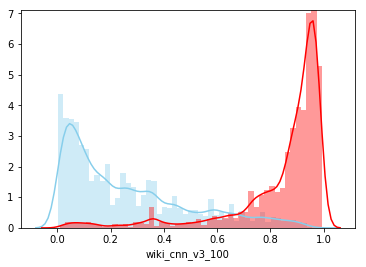

In [8]:
toxic_scores = balanced_madlibs.query('label == True')['wiki_cnn_v3_100']
non_toxic_scores = balanced_madlibs.query('label == False')['wiki_cnn_v3_100']

sns.distplot( non_toxic_scores , color="skyblue", label="Sepal Length")
sns.distplot( toxic_scores , color="red", label="Sepal Width")
#sns.plt.legend()


In [14]:
# Add columns for each subgroup.
f = open('bias_madlibs_data/adjectives_people.txt', 'r')
terms = [line.strip() for line in f]
model_bias_analysis.add_subgroup_columns_from_text(balanced_madlibs, 'text', terms)

In [5]:
def plot_histogram(identity):
    toxic_scores = balanced_madlibs.query(identity + ' == True & label == True')['wiki_cnn_v3_100']
    non_toxic_scores = balanced_madlibs.query(identity + ' == True & label == False')['wiki_cnn_v3_100']
    sns.distplot( non_toxic_scores , color="skyblue", axlabel=identity)
    sns.distplot( toxic_scores , color="red", axlabel=identity)
    plt.figure()


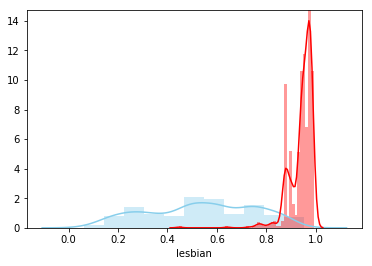

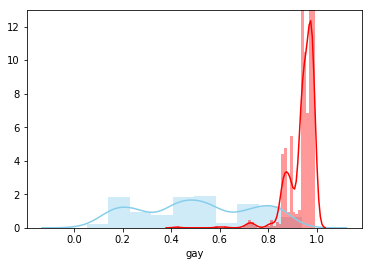

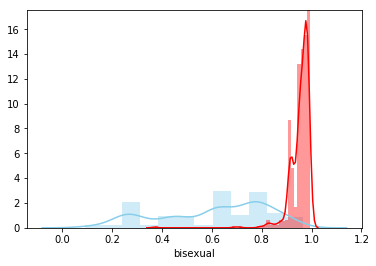

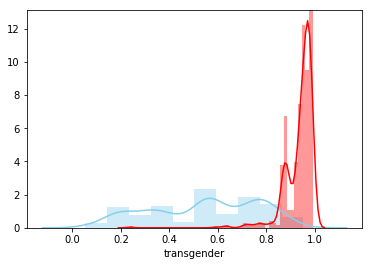

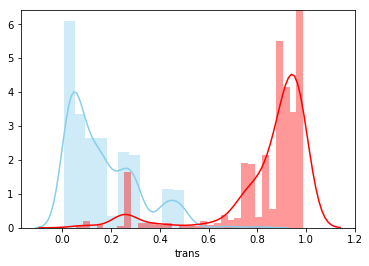

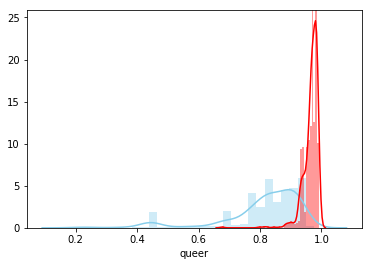

In [15]:
# These are the identities we intentionally skewed
for identity in ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer']:
    plot_histogram(identity)

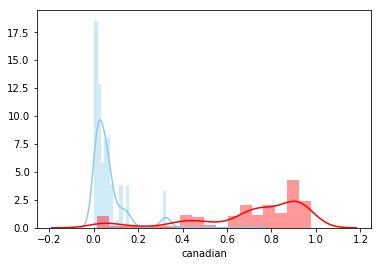

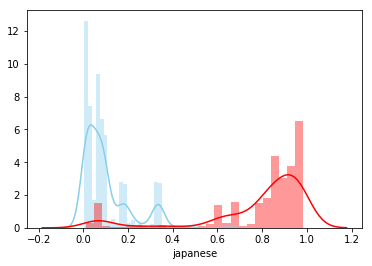

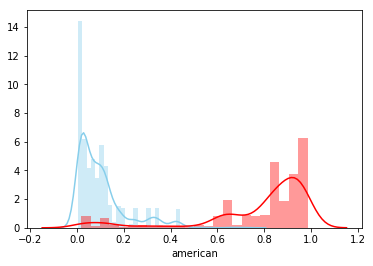

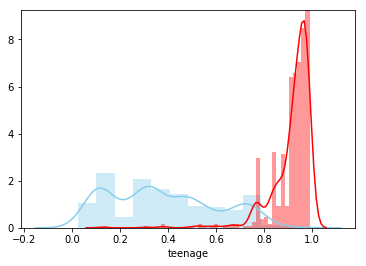

In [16]:
# These identities surprising did better with normed pinned auc
for identity in ['canadian', 'japanese', 'american', 'teenage']:
    plot_histogram(identity)

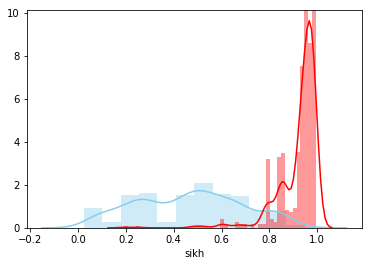

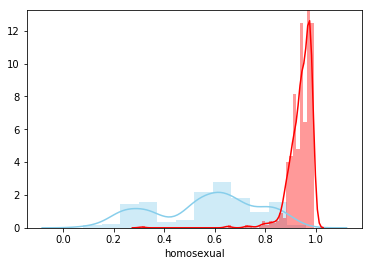

In [17]:
# These identities did a little worse
for identity in ['sikh', 'homosexual']:
    plot_histogram(identity)

In [182]:
# both skews should drop the same number of records
def get_skew_size(balanced, subgroup):
    return len(balanced[balanced[subgroup] & ~balanced['label']]) // 2

def skew_group(balanced, subgroup, label):
    non_toxic_subgroup_items = balanced[balanced[subgroup] & ~balanced[label]]
    drop_indices = np.random.choice(
        non_toxic_subgroup_items.index, get_skew_size(balanced, subgroup), replace=False)
    #print('skew_group len ' + str(len(drop_indices)))
    return balanced.drop(drop_indices)

def skew_group_evenly(balanced, subgroup):
    subgroup_items = balanced[balanced[subgroup]]
    drop_indices = np.random.choice(
        subgroup_items.index, get_skew_size(balanced, subgroup), replace=False)
    #print('skew_group_evenly len ' + str(len(drop_indices)))
    return balanced.drop(drop_indices)

In [183]:
def run_iterations(num_iterations, identity_array, output_csv_path, shrink_balanced_set):
    df = pd.DataFrame()
    for i in xrange(num_iterations):
        # print out some steps along the way just to keep track of progress
        if i % 10 == 0:
            print('%d iterations complete' % i)
            
        unbalanced_madlibs = balanced_madlibs
        balanced_madlibs_modified = pd.DataFrame.copy(balanced_madlibs)
        
        #print('before ' + str(len(balanced_madlibs_modified)))
        for group in identity_array:
            unbalanced_madlibs = skew_group(unbalanced_madlibs, group, 'label')
            if shrink_balanced_set:
                balanced_madlibs_modified = skew_group_evenly(balanced_madlibs_modified, group)
        #print('after ' + str(len(balanced_madlibs_modified)))

        balanced_pinned_auc_results = model_bias_analysis.per_subgroup_aucs(balanced_madlibs_modified, terms, model_families, 'label')
        unbalanced_pinned_auc_results = model_bias_analysis.per_subgroup_aucs(unbalanced_madlibs, terms, model_families, 'label')

        subgroups = list(balanced_pinned_auc_results.subgroup)
        balanced_pinned_aucs = [a[0] for a in balanced_pinned_auc_results.wiki_cnn_v3_100_aucs]
        balanced_normed_pinned_aucs = [a[0] for a in balanced_pinned_auc_results.wiki_cnn_v3_100_normalized_pinned_aucs]
        unbalanced_pinned_aucs = [a[0] for a in unbalanced_pinned_auc_results.wiki_cnn_v3_100_aucs]
        unbalanced_normed_pinned_aucs = [a[0] for a in unbalanced_pinned_auc_results.wiki_cnn_v3_100_normalized_pinned_aucs]

        df = df.append(
            pd.DataFrame({
                'iteration': i,
                'subgroup': subgroups,
                'pinned_auc_balanced_set': balanced_pinned_aucs,
                'normed_pinned_auc_balanced_set': balanced_normed_pinned_aucs,
                'pinned_auc_unbalanced_set': unbalanced_pinned_aucs,
                'normed_pinned_auc_unbalanced_set': unbalanced_normed_pinned_aucs},
                columns=['iteration', 'subgroup', 'pinned_auc_balanced_set', 'pinned_auc_unbalanced_set', 'normed_pinned_auc_balanced_set', 'normed_pinned_auc_unbalanced_set']), ignore_index=True)
        df['pinned_auc_diff'] = df['pinned_auc_balanced_set'] - df['pinned_auc_unbalanced_set']
        df['normed_pinned_auc_diff'] = df['normed_pinned_auc_balanced_set'] - df['normed_pinned_auc_unbalanced_set']
    df.to_csv(output_csv_path)  # TODO: maybe auto generate this path based on identities and num_iterations

In [187]:
# run_iterations(1000, ['queer'], 'mann_whitney_analysis_skew_queer_only.csv')
run_iterations(1000, ['queer'], 'mann_whitney_analysis_skew_queer_only_skewed_balanced_set_no_sampling.csv', True)

0 iterations complete
10 iterations complete
20 iterations complete
30 iterations complete
40 iterations complete
50 iterations complete
60 iterations complete
70 iterations complete
80 iterations complete
90 iterations complete
100 iterations complete
110 iterations complete
120 iterations complete
130 iterations complete
140 iterations complete
150 iterations complete
160 iterations complete
170 iterations complete
180 iterations complete
190 iterations complete
200 iterations complete
210 iterations complete
220 iterations complete
230 iterations complete
240 iterations complete
250 iterations complete
260 iterations complete
270 iterations complete
280 iterations complete
290 iterations complete
300 iterations complete
310 iterations complete
320 iterations complete
330 iterations complete
340 iterations complete
350 iterations complete
360 iterations complete
370 iterations complete
380 iterations complete
390 iterations complete
400 iterations complete
410 iterations complete
420

In [170]:
# Use this logic to read and write CSV files, so we don't always need to re-run the above 1000 iterations

# FILE = 'mann_whitney_analysis_skew_lesbian_gay_bisexual_transgender_trans_queer.csv'
# df.to_csv(FILE)
# df = pd.read_csv(FILE)

# FILE = 'mann_whitney_analysis_skew_queer_only.csv'
# df.to_csv(FILE)

In [18]:
def print_table_from_csv(filepath):
    # This code does the absolute value BEFORE grouping + taking the mean
    # Copy is needed to not affect the original columns (by setting absolute values)
    abs_df = pd.read_csv(filepath)
    abs_df['normed_pinned_auc_diff'] = abs_df['normed_pinned_auc_diff'].abs()
    abs_df['pinned_auc_diff'] = abs_df['pinned_auc_diff'].abs()
    mean_columns = ['subgroup', 'normed_pinned_auc_diff', 'pinned_auc_diff']
    mean_df = abs_df[mean_columns].groupby('subgroup').mean()

    normed_pinned_auc_diff_abs = mean_df['normed_pinned_auc_diff'].abs()
    pinned_auc_diff_abs = mean_df['pinned_auc_diff'].abs()
    mean_df['is_abs_normed_less?'] = np.where(normed_pinned_auc_diff_abs < pinned_auc_diff_abs, '', 'NO')
    mean_df['how_much_less?'] = pinned_auc_diff_abs - normed_pinned_auc_diff_abs

    return mean_df.sort_values('how_much_less?')

In [19]:
print_table_from_csv('mann_whitney_analysis_skew_queer_only_skewed_balanced_set_no_sampling.csv')

,normed_pinned_auc_diff,pinned_auc_diff,is_abs_normed_less?,how_much_less?
subgroup,,,,
african,0.000710,0.001937,,0.001227
american,0.000616,0.001851,,0.001234
indian,0.000743,0.002522,,0.001779
japanese,0.000593,0.002373,,0.001780
canadian,0.000813,0.002627,,0.001814
african american,0.000617,0.002500,,0.001882
middle aged,0.000627,0.002533,,0.001905
younger,0.000604,0.002533,,0.001929
older,0.000660,0.002593,,0.001933


In [185]:
print_table_from_csv('mann_whitney_analysis_skew_queer_only_skewed_balanced_set.csv')

,normed_pinned_auc_diff,pinned_auc_diff,is_abs_normed_less?,how_much_less?
subgroup,,,,
bisexual,0.003248,0.003666,,0.000418
homosexual,0.002917,0.003398,,0.000480
transgender,0.003090,0.003626,,0.000535
lesbian,0.003115,0.003688,,0.000574
gay,0.002824,0.003408,,0.000584
african,0.001207,0.001798,,0.000591
sikh,0.002674,0.003282,,0.000608
middle eastern,0.002177,0.002800,,0.000623
black,0.002250,0.002968,,0.000718


In [165]:
print_table_from_csv('mann_whitney_analysis_skew_queer_only.csv')

,normed_pinned_auc_diff,pinned_auc_diff,is_abs_normed_less?,how_much_less?
subgroup,,,,
homosexual,0.003103,0.002334,NO,-0.000770
sikh,0.002686,0.002424,NO,-0.000262
transgender,0.002215,0.002498,,0.000283
european,0.001640,0.002114,,0.000474
black,0.001908,0.002411,,0.000504
blind,0.001824,0.002334,,0.000510
african,0.001089,0.001602,,0.000513
hispanic,0.001656,0.002189,,0.000533
bisexual,0.003278,0.003850,,0.000573


In [163]:
print_table_from_csv('mann_whitney_analysis_skew_lesbian_gay_bisexual_transgender_trans_queer.csv')

,normed_pinned_auc_diff,pinned_auc_diff,is_abs_normed_less?,how_much_less?
subgroup,,,,
sikh,0.002710,0.002532,NO,-0.000177
homosexual,0.002673,0.002504,NO,-0.000169
indian,0.001620,0.002016,,0.000397
mexican,0.001428,0.001917,,0.000489
middle aged,0.001402,0.001894,,0.000492
latino,0.001433,0.002000,,0.000568
catholic,0.001282,0.001865,,0.000582
black,0.001604,0.002192,,0.000588
lgbt,0.001509,0.002118,,0.000609


In [150]:
# THIS IS THE OLD LOGIC that does the absolute value AFTER grouping + taking the mean

# mean_columns = ['subgroup', 'normed_pinned_auc_diff', 'pinned_auc_diff']
# # Copy is needed to not affect the original columns (by setting absolute values)
# mean_df_old = pd.DataFrame.copy(df)[mean_columns].groupby('subgroup').mean()

# normed_pinned_auc_diff_abs = mean_df_old['normed_pinned_auc_diff'].abs()
# pinned_auc_diff_abs = mean_df_old['pinned_auc_diff'].abs()

# mean_df_old['is_abs_normed_less?'] = np.where(normed_pinned_auc_diff_abs < pinned_auc_diff_abs, '', 'NO')

# mean_df_old['how_much_less?'] = pinned_auc_diff_abs - normed_pinned_auc_diff_abs

# mean_df_old.sort_values('how_much_less?')

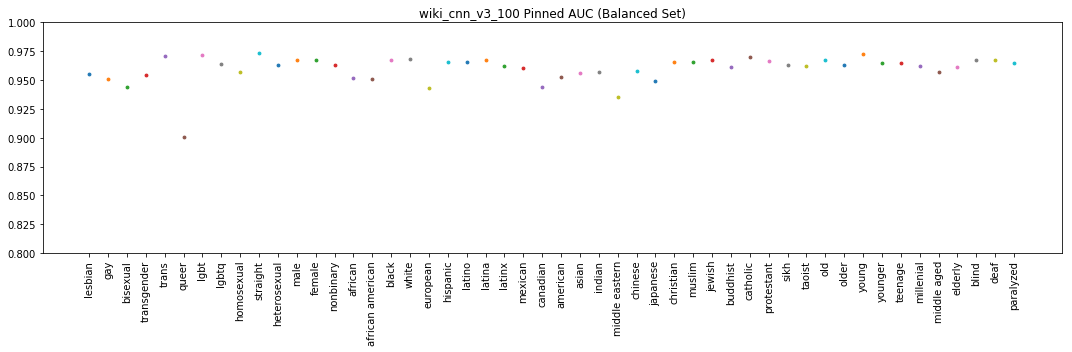

In [8]:
# TODO: should I keep this stuff?

for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
        balanced_pinned_auc_results,
        'subgroup',
        name + '_aucs',
        title=name + ' Pinned AUC (Balanced Set)',
        y_lim=(0.8, 1.0))

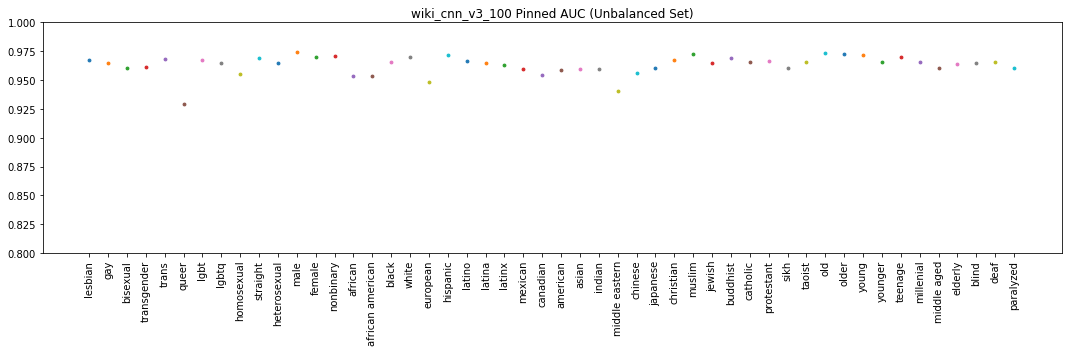

In [9]:
for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
        unbalanced_pinned_auc_results,
        'subgroup',
        name + '_aucs',
        title=name + ' Pinned AUC (Unbalanced Set)',
        y_lim=(0.8, 1.0))

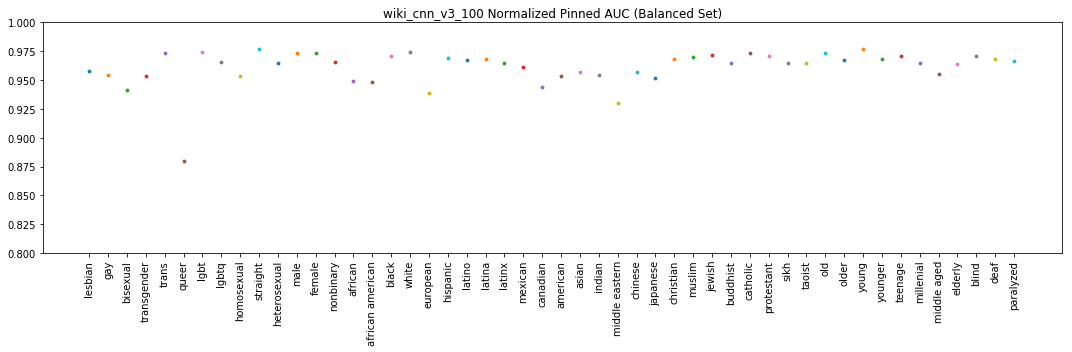

In [10]:
for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
        balanced_pinned_auc_results,
        'subgroup',
        name + '_normalized_pinned_aucs',
        title=name + ' Normalized Pinned AUC (Balanced Set)',
        y_lim=(0.8, 1.0))

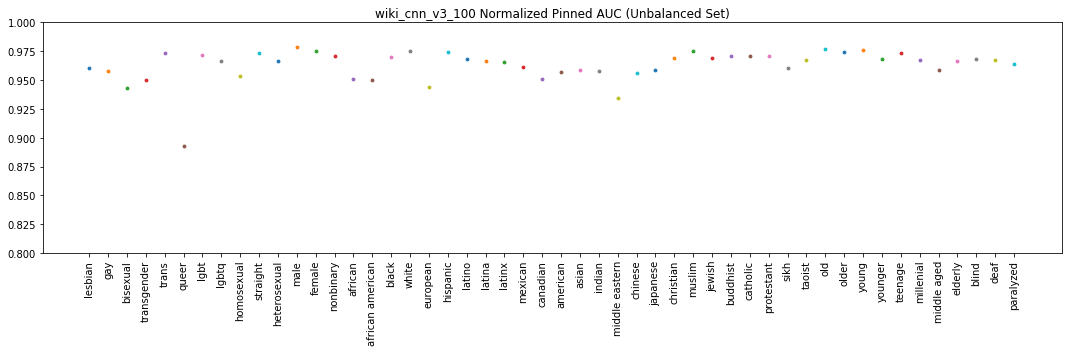

In [11]:
for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
        unbalanced_pinned_auc_results,
        'subgroup',
        name + '_normalized_pinned_aucs',
        title=name + ' Normalized Pinned AUC (Unbalanced Set)',
        y_lim=(0.8, 1.0))

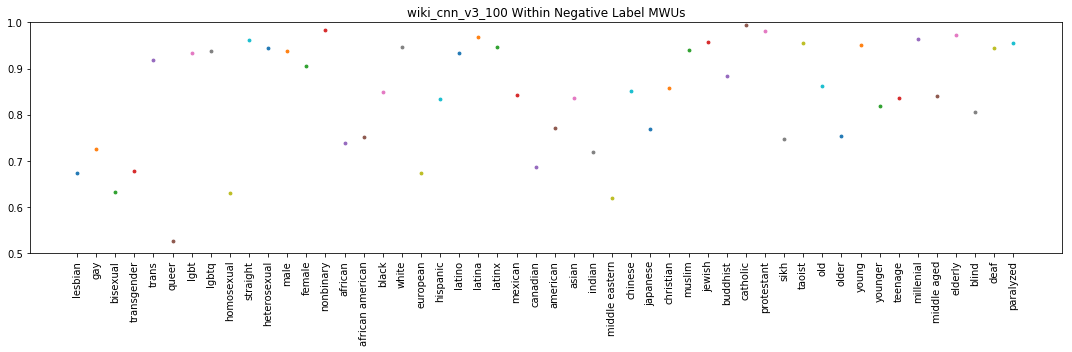

In [12]:
for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
        balanced_pinned_auc_results,
        'subgroup',
        name + '_within_negative_label_mwus',
        title=name + ' Within Negative Label MWUs',
        y_lim=(0.5, 1.0))

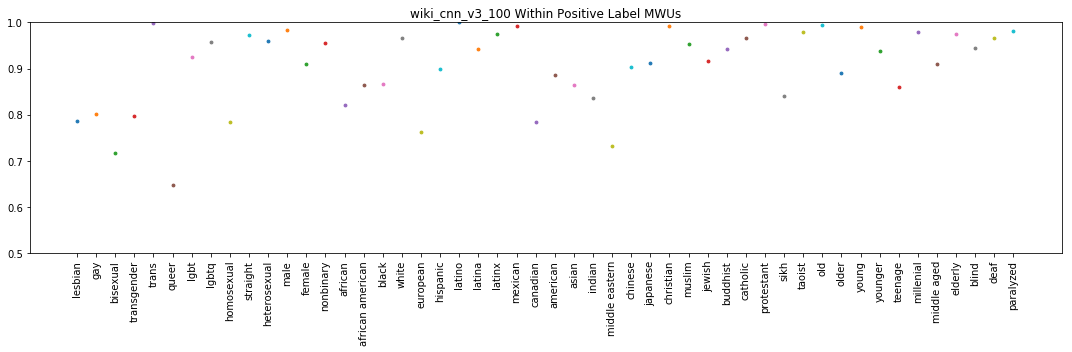

In [13]:
for family in model_families:
    name = model_bias_analysis.model_family_name(family)
    model_bias_analysis.per_subgroup_scatterplots(
         balanced_pinned_auc_results,
        'subgroup',
        name + '_within_positive_label_mwus',
        title=name + ' Within Positive Label MWUs',
        y_lim=(0.5, 1.0))